In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_probability.python.distributions as tfd
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Layer

reference : 
1. [MXNET - Bayes by Backprop from Scratch (NN, Classification)](https://gluon.mxnet.io/chapter18_variational-methods-and-uncertainty/bayes-by-backprop.html)

2. [Paper - Weight Uncertainty in Neural Networks](https://arxiv.org/pdf/1505.05424.pdf)

3. [Variational inference for bayesian neural networks](http://krasserm.github.io/2019/03/14/bayesian-neural-networks/)

4. [몬테카를로 샘플링의 마법](http://www.secmem.org/blog/2019/01/11/mcmc/)





## Example : Small Dataset with Large Noise
---

> 아래와 같이, 데이터 내에 noise가 강하면서 데이터 수가 매우 적은 상황을 가정해 봅시다.

In [2]:
def f(x, sigma):
    noise = np.random.normal(size=x.shape) * sigma
    return 10 * np.sin(2 * np.pi * (x-0.3)) + noise

train_size = 64
noise_strength = 1.0

X = np.linspace(-1., 1., train_size).reshape(-1, 1)
Y = f(X, sigma=noise_strength)
Y_true = f(X, sigma=0.0)

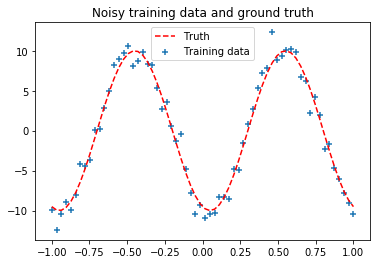

In [3]:
plt.title('Noisy training data and ground truth')

plt.scatter(X, Y, marker='+', label='Training data')
plt.plot(X, Y_true, 'r--', label='Truth')
plt.legend()
plt.show()

Bayes by Back Propagation을 통해 Bayesian Neural Network 모델을 학습시켜 보도록 하겠습니다.

# \[Bayes By BackPropagation\]
----

우리가 원하는 것은 아래의 Posterior($P(W|D)$)를 구하는 것.

$$
P(W|D) = \frac{P(D|W) \cdot P(W)}{P(D)}
$$

## 1. Prior Distribution 정의하기
---

Bayesian Back Propogation 논문에서는 Prior를 Gaussian Prior과 Scale Mixture Prior 중에서 골라 썼습니다. 이번은 가장 간단한 Gaussian Prior을 이용하도록 하겠습니다.

In [4]:
sigma = K.variable(1., name='sigma')
prior = tfd.Normal(loc=0., scale=sigma)

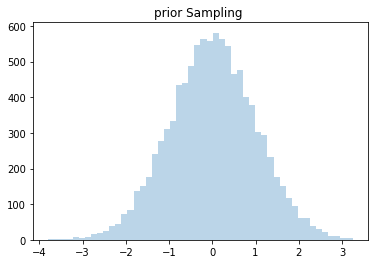

In [5]:
# Prior Sampling 하기
sampling_result = K.get_session().run(prior.sample(10000))

plt.title("prior Sampling ")
plt.hist(sampling_result,bins=50,alpha=0.3)
plt.show()

## 2. Variational Dense Layer 구현하기
---

기존의 Dense Layer는 각 Weight가 고정된 값을 가지고 있었습니다. 아래와 같죠.<br>
![](https://github.com/zackchase/mxnet-the-straight-dope/blob/master/img/bbb_nn_classic.png?raw=true)

하지만 Bayesian에서의 Weight는 값이 아닌 분포의 형태를 띄고 있습니다. 마치 아래처럼요<br>

![](https://github.com/zackchase/mxnet-the-straight-dope/blob/master/img/bbb_nn_bayes.png?raw=true)

우리는 위와 같이 동작하는 녀석을 만들어 주어야 합니다.

In [42]:
from tensorflow.keras.layers import Layer
from tensorflow.keras.initializers import RandomNormal, Constant
class VariationalDense(Layer):
    """ 
    그냥 Fully Connected Layer가 아닌, 
    Variational Fully Connected Layer
    """
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super().__init__(**kwargs)

    def build(self, input_shape):
        shape = input_shape.as_list()
        batch_size, input_dim = shape
        # Shape of Kernel : (input dim, output dim )
        k_loc = self.add_weight(name='kernel_mean',
                                shape=(input_dim, self.output_dim),
                                initializer=RandomNormal(stddev=1.),
                                trainable=True)
        k_scale = self.add_weight(name='kernel_std',
                                  shape=(input_dim, self.output_dim),
                                  initializer=Constant(0.),
                                  trainable=True)
        # kernel의 정규분포
        self.k_normal = tfd.Normal(loc=k_loc, scale=K.softplus(k_scale))
        
        # Shape of Bias : (output dim, )        
        b_loc = self.add_weight(name='bias_mean',
                                shape=(self.output_dim,),
                                initializer=RandomNormal(stddev=1.),                                
                                trainable=True)
        b_scale = self.add_weight(name='bias_scale',
                                  shape=(self.output_dim,),
                                  initializer=Constant(0.),                                  
                                  trainable=True)
        # bias의 정규분포
        self.b_normal = tfd.Normal(loc=b_loc, scale=K.softplus(b_scale))
        super().build(input_shape)
    
    def call(self, inputs, **kwargs):
        # Feed-Forward 시의 연산
        kernel = self.k_normal.sample() # kernel을 샘플링
        bias = self.b_normal.sample() # bias를 샘플링
        return K.dot(inputs, kernel) + bias
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

그냥 Fully Connected Layer라면 아래처럼 구성될 것입니다.

In [43]:
class NaiveDense(Layer):
    """ 
    그냥 Fully Connected Layer
    """
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super().__init__(**kwargs)

    def build(self, input_shape):
        shape = input_shape.as_list()
        batch_size, input_dim = shape

        # Shape of Kernel : (input dim, output dim )
        self.kernel = self.add_weight(name='kernel',
                                shape=(input_dim, self.output_dim))
        # Shape of Bias : (output dim, )  
        self.bias = self.add_weight(name='bias',
                                    shape=(self.output_dim))
        super().build(input_shape)
    
    def call(self, inputs, **kwargs):
        # Feed-Forward 시의 연산
        return K.dot(inputs, self.kernel) + self.bias
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

## 3. 3층짜리 Variational Neural network 구성하기
---

In [98]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

In [120]:
K.clear_session()

sigma = K.variable(.5, name='sigma')
K.get_session().run(sigma.initializer)
prior = tfd.Normal(loc=0., scale=sigma)

inputs = Input((1,),name='inputs')

vdense_1 = VariationalDense(40)
vdense_2 = VariationalDense(40)
vdense_out = VariationalDense(1)

x = vdense_1(inputs)
x = K.relu(x)
x = vdense_2(x)
x = K.relu(x)
output = vdense_out(x)

## 4. Loss 함수 구성하기
----

우리가 최적화시켜야 하는 목표 함수는 **Variational Free Energy** 입니다.

### (1) Likelihood

In [121]:
kld_k1 = vdense_1.k_normal.kl_divergence(prior)
kld_b1 = vdense_1.b_normal.kl_divergence(prior)

kld_k2 = vdense_2.k_normal.kl_divergence(prior)
kld_b2 = vdense_2.b_normal.kl_divergence(prior)

kld_kout = vdense_out.k_normal.kl_divergence(prior)
kld_bout = vdense_out.b_normal.kl_divergence(prior)

In [122]:
kld_loss = ( 
    tf.reduce_sum(kld_k1) + tf.reduce_sum(kld_b1) +
    tf.reduce_sum(kld_k2) + tf.reduce_sum(kld_b2) +
    tf.reduce_sum(kld_kout) + tf.reduce_sum(kld_bout)
)

### (2) Likelihood

In [123]:
y_train = Input((1,),name='y_train')
mse = tf.reduce_mean((y_train - output)**2)

In [124]:
loss = mse + kld_loss

## 5. Model Compile하기
---

In [125]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [126]:
model = Model(inputs=[inputs, y_train],outputs=[loss])

model.add_loss(loss)
model.compile(Adam(1e-4),)

W0825 08:45:56.055038 4620060096 training_utils.py:1101] Output tf_op_layer_add_5 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to tf_op_layer_add_5.


## 6. Model Fitting하기
---

In [132]:
hist = model.fit(x=[X,Y],batch_size=64,
                 epochs=100000, verbose=2)

Epoch 1/100000
64/64 - 0s - loss: 91.9882
Epoch 2/100000
64/64 - 0s - loss: 64.6613
Epoch 3/100000
64/64 - 0s - loss: 60.9710
Epoch 4/100000
64/64 - 0s - loss: 59.8083
Epoch 5/100000
64/64 - 0s - loss: 63.0382
Epoch 6/100000
64/64 - 0s - loss: 72.6629
Epoch 7/100000
64/64 - 0s - loss: 71.7228
Epoch 8/100000
64/64 - 0s - loss: 61.0427
Epoch 9/100000
64/64 - 0s - loss: 96.6911
Epoch 10/100000
64/64 - 0s - loss: 61.2364
Epoch 11/100000
64/64 - 0s - loss: 68.7651
Epoch 12/100000
64/64 - 0s - loss: 61.6704
Epoch 13/100000
64/64 - 0s - loss: 65.5138
Epoch 14/100000
64/64 - 0s - loss: 61.7741
Epoch 15/100000
64/64 - 0s - loss: 85.6958
Epoch 16/100000
64/64 - 0s - loss: 60.9843
Epoch 17/100000
64/64 - 0s - loss: 81.2798
Epoch 18/100000
64/64 - 0s - loss: 65.5683
Epoch 19/100000
64/64 - 0s - loss: 61.2071
Epoch 20/100000
64/64 - 0s - loss: 70.3478
Epoch 21/100000
64/64 - 0s - loss: 61.8819
Epoch 22/100000
64/64 - 0s - loss: 60.8355
Epoch 23/100000
64/64 - 0s - loss: 69.3182
Epoch 24/100000
64/6

Epoch 190/100000
64/64 - 0s - loss: 59.5230
Epoch 191/100000
64/64 - 0s - loss: 70.3990
Epoch 192/100000
64/64 - 0s - loss: 60.5652
Epoch 193/100000
64/64 - 0s - loss: 75.7765
Epoch 194/100000
64/64 - 0s - loss: 62.2892
Epoch 195/100000
64/64 - 0s - loss: 94.1949
Epoch 196/100000
64/64 - 0s - loss: 87.4585
Epoch 197/100000
64/64 - 0s - loss: 74.8223
Epoch 198/100000
64/64 - 0s - loss: 63.3284
Epoch 199/100000
64/64 - 0s - loss: 59.9582
Epoch 200/100000
64/64 - 0s - loss: 61.7504
Epoch 201/100000
64/64 - 0s - loss: 63.6224
Epoch 202/100000
64/64 - 0s - loss: 71.3729
Epoch 203/100000
64/64 - 0s - loss: 61.3123
Epoch 204/100000
64/64 - 0s - loss: 63.6467
Epoch 205/100000
64/64 - 0s - loss: 61.1857
Epoch 206/100000
64/64 - 0s - loss: 60.4074
Epoch 207/100000
64/64 - 0s - loss: 62.8524
Epoch 208/100000
64/64 - 0s - loss: 63.0813
Epoch 209/100000
64/64 - 0s - loss: 64.0370
Epoch 210/100000
64/64 - 0s - loss: 66.6115
Epoch 211/100000
64/64 - 0s - loss: 61.2171
Epoch 212/100000
64/64 - 0s - lo

64/64 - 0s - loss: 64.0525
Epoch 377/100000
64/64 - 0s - loss: 74.2547
Epoch 378/100000
64/64 - 0s - loss: 61.0662
Epoch 379/100000
64/64 - 0s - loss: 60.0269
Epoch 380/100000
64/64 - 0s - loss: 62.4904
Epoch 381/100000
64/64 - 0s - loss: 62.9608
Epoch 382/100000
64/64 - 0s - loss: 61.1543
Epoch 383/100000
64/64 - 0s - loss: 63.6228
Epoch 384/100000
64/64 - 0s - loss: 60.7330
Epoch 385/100000
64/64 - 0s - loss: 67.8501
Epoch 386/100000
64/64 - 0s - loss: 60.9163
Epoch 387/100000
64/64 - 0s - loss: 60.0572
Epoch 388/100000
64/64 - 0s - loss: 63.4862
Epoch 389/100000
64/64 - 0s - loss: 62.5366
Epoch 390/100000
64/64 - 0s - loss: 63.7640
Epoch 391/100000
64/64 - 0s - loss: 64.8564
Epoch 392/100000
64/64 - 0s - loss: 93.1959
Epoch 393/100000
64/64 - 0s - loss: 70.3995
Epoch 394/100000
64/64 - 0s - loss: 60.7820
Epoch 395/100000
64/64 - 0s - loss: 66.3935
Epoch 396/100000
64/64 - 0s - loss: 60.3355
Epoch 397/100000
64/64 - 0s - loss: 87.5513
Epoch 398/100000
64/64 - 0s - loss: 64.7109
Epoch

Epoch 563/100000
64/64 - 0s - loss: 63.4822
Epoch 564/100000
64/64 - 0s - loss: 62.0361
Epoch 565/100000
64/64 - 0s - loss: 58.8642
Epoch 566/100000
64/64 - 0s - loss: 62.6886
Epoch 567/100000
64/64 - 0s - loss: 59.8217
Epoch 568/100000
64/64 - 0s - loss: 65.9566
Epoch 569/100000
64/64 - 0s - loss: 66.6717
Epoch 570/100000
64/64 - 0s - loss: 59.8645
Epoch 571/100000
64/64 - 0s - loss: 60.7688
Epoch 572/100000
64/64 - 0s - loss: 66.1812
Epoch 573/100000
64/64 - 0s - loss: 74.7654
Epoch 574/100000
64/64 - 0s - loss: 60.9134
Epoch 575/100000
64/64 - 0s - loss: 65.1191
Epoch 576/100000
64/64 - 0s - loss: 63.0401
Epoch 577/100000
64/64 - 0s - loss: 58.4248
Epoch 578/100000
64/64 - 0s - loss: 62.8378
Epoch 579/100000
64/64 - 0s - loss: 59.3481
Epoch 580/100000
64/64 - 0s - loss: 60.0714
Epoch 581/100000
64/64 - 0s - loss: 66.2166
Epoch 582/100000
64/64 - 0s - loss: 65.7427
Epoch 583/100000
64/64 - 0s - loss: 62.3012
Epoch 584/100000
64/64 - 0s - loss: 58.4408
Epoch 585/100000
64/64 - 0s - lo

64/64 - 0s - loss: 65.2365
Epoch 750/100000
64/64 - 0s - loss: 87.0928
Epoch 751/100000
64/64 - 0s - loss: 59.0546
Epoch 752/100000
64/64 - 0s - loss: 60.3258
Epoch 753/100000
64/64 - 0s - loss: 60.8989
Epoch 754/100000
64/64 - 0s - loss: 61.9185
Epoch 755/100000
64/64 - 0s - loss: 59.9850
Epoch 756/100000
64/64 - 0s - loss: 66.3324
Epoch 757/100000
64/64 - 0s - loss: 63.1848
Epoch 758/100000
64/64 - 0s - loss: 59.9781
Epoch 759/100000
64/64 - 0s - loss: 62.2878
Epoch 760/100000
64/64 - 0s - loss: 74.7903
Epoch 761/100000
64/64 - 0s - loss: 57.8720
Epoch 762/100000
64/64 - 0s - loss: 59.6758
Epoch 763/100000
64/64 - 0s - loss: 60.7508
Epoch 764/100000
64/64 - 0s - loss: 67.5267
Epoch 765/100000
64/64 - 0s - loss: 64.9203
Epoch 766/100000
64/64 - 0s - loss: 67.6904
Epoch 767/100000
64/64 - 0s - loss: 66.1505
Epoch 768/100000
64/64 - 0s - loss: 61.5305
Epoch 769/100000
64/64 - 0s - loss: 63.5847
Epoch 770/100000
64/64 - 0s - loss: 69.2798
Epoch 771/100000
64/64 - 0s - loss: 67.3814
Epoch

Epoch 936/100000
64/64 - 0s - loss: 71.0734
Epoch 937/100000
64/64 - 0s - loss: 64.2058
Epoch 938/100000
64/64 - 0s - loss: 61.6437
Epoch 939/100000
64/64 - 0s - loss: 60.5172
Epoch 940/100000
64/64 - 0s - loss: 61.4513
Epoch 941/100000
64/64 - 0s - loss: 58.3011
Epoch 942/100000
64/64 - 0s - loss: 60.0989
Epoch 943/100000
64/64 - 0s - loss: 58.0107
Epoch 944/100000
64/64 - 0s - loss: 62.2848
Epoch 945/100000
64/64 - 0s - loss: 66.4489
Epoch 946/100000
64/64 - 0s - loss: 62.9996
Epoch 947/100000
64/64 - 0s - loss: 59.0631
Epoch 948/100000
64/64 - 0s - loss: 61.1158
Epoch 949/100000
64/64 - 0s - loss: 71.3879
Epoch 950/100000
64/64 - 0s - loss: 74.7410
Epoch 951/100000
64/64 - 0s - loss: 66.0249
Epoch 952/100000
64/64 - 0s - loss: 58.6276
Epoch 953/100000
64/64 - 0s - loss: 59.3934
Epoch 954/100000
64/64 - 0s - loss: 61.0933
Epoch 955/100000
64/64 - 0s - loss: 60.3560
Epoch 956/100000
64/64 - 0s - loss: 58.0617
Epoch 957/100000
64/64 - 0s - loss: 74.0422
Epoch 958/100000
64/64 - 0s - lo

Epoch 1120/100000
64/64 - 0s - loss: 61.0061
Epoch 1121/100000
64/64 - 0s - loss: 59.2578
Epoch 1122/100000
64/64 - 0s - loss: 60.9514
Epoch 1123/100000
64/64 - 0s - loss: 74.5202
Epoch 1124/100000
64/64 - 0s - loss: 68.1254
Epoch 1125/100000
64/64 - 0s - loss: 59.7619
Epoch 1126/100000
64/64 - 0s - loss: 58.1658
Epoch 1127/100000
64/64 - 0s - loss: 59.6617
Epoch 1128/100000
64/64 - 0s - loss: 61.9055
Epoch 1129/100000
64/64 - 0s - loss: 71.5703
Epoch 1130/100000
64/64 - 0s - loss: 59.0411
Epoch 1131/100000
64/64 - 0s - loss: 59.8464
Epoch 1132/100000
64/64 - 0s - loss: 67.0137
Epoch 1133/100000
64/64 - 0s - loss: 62.8422
Epoch 1134/100000
64/64 - 0s - loss: 67.5530
Epoch 1135/100000
64/64 - 0s - loss: 79.8991
Epoch 1136/100000
64/64 - 0s - loss: 60.7896
Epoch 1137/100000
64/64 - 0s - loss: 69.9308
Epoch 1138/100000
64/64 - 0s - loss: 59.0591
Epoch 1139/100000
64/64 - 0s - loss: 69.0641
Epoch 1140/100000
64/64 - 0s - loss: 61.4936
Epoch 1141/100000
64/64 - 0s - loss: 76.5071
Epoch 1142

Epoch 1302/100000
64/64 - 0s - loss: 59.7388
Epoch 1303/100000
64/64 - 0s - loss: 63.2218
Epoch 1304/100000
64/64 - 0s - loss: 65.7695
Epoch 1305/100000
64/64 - 0s - loss: 69.5138
Epoch 1306/100000
64/64 - 0s - loss: 61.5284
Epoch 1307/100000
64/64 - 0s - loss: 64.1580
Epoch 1308/100000
64/64 - 0s - loss: 112.1269
Epoch 1309/100000
64/64 - 0s - loss: 62.6688
Epoch 1310/100000
64/64 - 0s - loss: 59.3026
Epoch 1311/100000
64/64 - 0s - loss: 72.7618
Epoch 1312/100000
64/64 - 0s - loss: 63.7415
Epoch 1313/100000
64/64 - 0s - loss: 58.8797
Epoch 1314/100000
64/64 - 0s - loss: 57.8979
Epoch 1315/100000
64/64 - 0s - loss: 63.3305
Epoch 1316/100000
64/64 - 0s - loss: 63.1161
Epoch 1317/100000
64/64 - 0s - loss: 59.1678
Epoch 1318/100000
64/64 - 0s - loss: 62.3960
Epoch 1319/100000
64/64 - 0s - loss: 71.4774
Epoch 1320/100000
64/64 - 0s - loss: 58.8851
Epoch 1321/100000
64/64 - 0s - loss: 65.2983
Epoch 1322/100000
64/64 - 0s - loss: 58.8162
Epoch 1323/100000
64/64 - 0s - loss: 94.1715
Epoch 132

Epoch 1484/100000
64/64 - 0s - loss: 64.8242
Epoch 1485/100000
64/64 - 0s - loss: 61.6838
Epoch 1486/100000
64/64 - 0s - loss: 62.0881
Epoch 1487/100000
64/64 - 0s - loss: 59.3038
Epoch 1488/100000
64/64 - 0s - loss: 61.7213
Epoch 1489/100000
64/64 - 0s - loss: 78.5604
Epoch 1490/100000
64/64 - 0s - loss: 60.1534
Epoch 1491/100000
64/64 - 0s - loss: 69.7892
Epoch 1492/100000
64/64 - 0s - loss: 62.4417
Epoch 1493/100000
64/64 - 0s - loss: 67.2289
Epoch 1494/100000
64/64 - 0s - loss: 66.7211
Epoch 1495/100000
64/64 - 0s - loss: 58.9013
Epoch 1496/100000
64/64 - 0s - loss: 65.6916
Epoch 1497/100000
64/64 - 0s - loss: 63.5327
Epoch 1498/100000
64/64 - 0s - loss: 56.5938
Epoch 1499/100000
64/64 - 0s - loss: 63.5403
Epoch 1500/100000
64/64 - 0s - loss: 94.2155
Epoch 1501/100000
64/64 - 0s - loss: 65.8289
Epoch 1502/100000
64/64 - 0s - loss: 64.3123
Epoch 1503/100000
64/64 - 0s - loss: 61.2956
Epoch 1504/100000
64/64 - 0s - loss: 58.2866
Epoch 1505/100000
64/64 - 0s - loss: 58.1704
Epoch 1506

KeyboardInterrupt: 

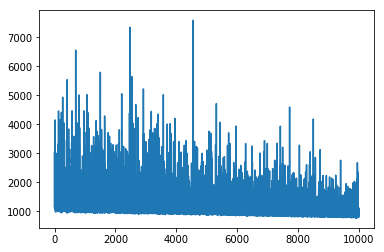

In [128]:
plt.plot(hist.history['loss'])

In [129]:
predictor = Model(inputs, output)

In [130]:
o = predictor.predict(X)

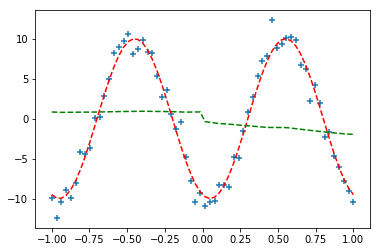

In [131]:
plt.scatter(X, Y, marker='+', label='Training data')
plt.plot(X, Y_true, 'r--', label='Truth')
plt.plot(X, o, 'g--', label='Predcited')
plt.show()